In [2]:
import pandas as pd
import numpy as np
from numpy import pi, sin, cos, arccos
from astropy.coordinates import get_sun
from astropy.time import Time
import astropy

from ArielUtils.Constants import *
from ArielUtils.Functions import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("Ariel_MCS_TPCs_01May2023.csv")

In [4]:
targets = df[['Star Name', 'Star RA', 'Star Dec', 'Planet Period [days]', 'Transit Duration [s]']]
targets.head(3)

,Star Name,Star RA,Star Dec,Planet Period [days],Transit Duration [s]
0,1007.01,112.752393,-4.463359,6.998921,14230.80000
1,1011.01,113.984761,-32.841999,2.470498,7887.60000
2,1015.01,122.895964,-27.971896,1.373499,5950.23876


In [8]:
initial_MJD_time = 60209.46657 # some chosen start time in modified julian date format (MJD)

current_ra = 0
current_dec = 0

time_since_short_calib = 0
time_since_long_calib = 0
time_elapsed = 0.
observed_events = 0
targets_observed = []
list_targets = targets.copy(deep=True)

# converting duration from years to minutes then cycling through 1 year of operation
while time_elapsed < MISSION_DURATION:
    current_time = Time(initial_MJD_time + time_elapsed/(60*24), 
                        format='mjd')
    
    # finding currently visible targets
    currently_visible = find_visible_targets(targets = list_targets, 
                                             time = current_time
                                             )
    
    # finds closest target
    closest_target = find_closest_target(targets = currently_visible, 
                                         currentRA = current_ra, 
                                         currentDEC = current_dec
                                         )
    
    # finds target with greatest fitness
    
    list_targets = list_targets.drop(closest_target.index) # drops target that has been observed
    
    targets_observed.append(closest_target['Star Name'].iloc[0]) # adds target to the list of observed targets
    
    target_dec, target_ra = closest_target['Star Dec'].iloc[0], closest_target['Star RA'].iloc[0]
    slewtime = find_slewtime_minutes(dec1 = np.radians(current_dec), 
                                     ra1 = np.radians(current_ra), 
                                     dec2 = np.radians(target_dec), 
                                     ra2 = np.radians(target_ra)
                                     )
    
    # updates current position
    current_dec, current_ra = target_dec, target_ra 
    
    # increases time by slewtime and average event duration (+ baseline)
    time_elapsed += slewtime + SETTLE_TIME
    time_elapsed += closest_target['Transit Duration [s]'].iloc[0]/60 *(1 + 2*BASELINE_RATIO)
    
    # calibration checks
    if time_since_long_calib > LONG_CALIBRATION_FREQUENCY:
        time_elapsed += LONG_CALIBRATION_DURATION
        time_since_long_calib = 0
        if time_since_long_calib > SHORT_CALIBRATION_FREQUENCY:
            time_since_short_calib = 0 # skips short calibration if long one overlaps. 
            
    elif time_since_short_calib > SHORT_CALIBRATION_FREQUENCY:
        time_elapsed += SHORT_CALIBRATION_DURATION
        time_since_short_calib = 0
    
    # increase number of observed events
    observed_events += 1

In [9]:
observed_events

1432

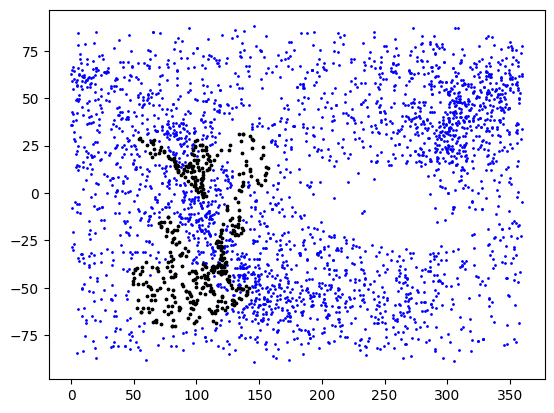

In [ ]:
targets_observed_df = []
for target in targets.iloc:
    if target['Star Name'] in targets_observed:
        targets_observed_df.append(target)
targets_observed_df = pd.DataFrame(targets_observed_df)

plt.scatter(targets['Star RA'], targets['Star Dec'], s=1, color='blue')
plt.scatter(targets_observed_df['Star RA'], targets_observed_df['Star Dec'], s=3, color='black')

plt.show()

1.0000000000000022

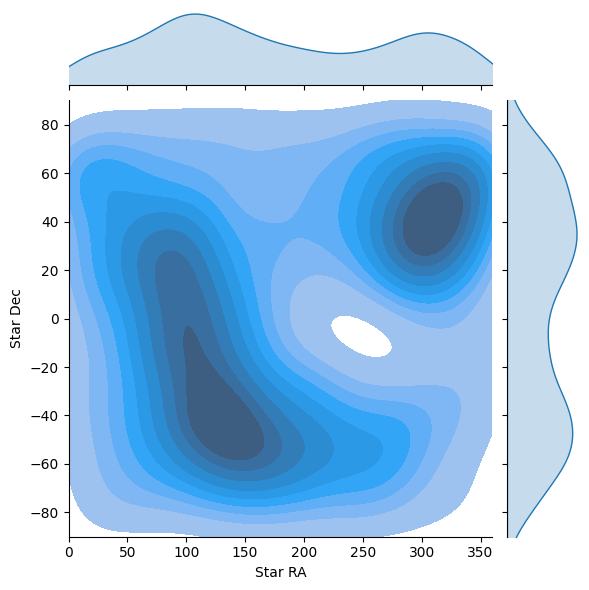

In [ ]:
# Quick plot to see where all targets are in the sky

# plt.scatter(targets['Star RA'], targets['Star Dec'], s=2) # scatter plot
sns.jointplot(x='Star RA', y='Star Dec', data=targets, kind="kde", fill=True, ylim=(-90, 90), xlim=(0,360)) # density plot

plt.show()

In [ ]:
# Quick plot to see where the visible targets are at an aforementionned time.

target_list = find_visible_targets()
target_list

# plt.scatter(target_list['Star RA'], target_list['Star Dec'], s=2) # scatter plot
sns.jointplot(x='Star RA', y='Star Dec', data=target_list, kind="kde", fill=True, ylim=(-90, 90), xlim=(0,360)) # density plot

plt.show()

NameError: name 'find_visible_targets' is not defined

0.8535533905932737